In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import copy

def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_data_3d(x_range, y_range, t_range, x_num, y_num, t_num):
    step_x = (x_range[1] - x_range[0]) / float(x_num-1)
    step_y = (y_range[1] - y_range[0]) / float(y_num-1)
    step_t = (t_range[1] - t_range[0]) / float(t_num-1)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]

    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    res = data.reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[0]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_left = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[1]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_right = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[0]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_lower = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[1]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_upper = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    return res, b_left, b_right, b_upper, b_lower

In [ ]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb



class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

/tmp/ipykernel_1802/1725142899.py:25: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [13]:
loss_track = []

for i in tqdm(range(1000)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


In [ ]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.019045, Loss_BC: 0.000005, Loss_IC: 0.178516
Train Loss: 0.197565


relative L1 error: 0.979464
relative L2 error: 0.978219


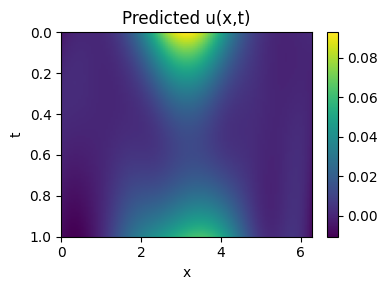

In [14]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

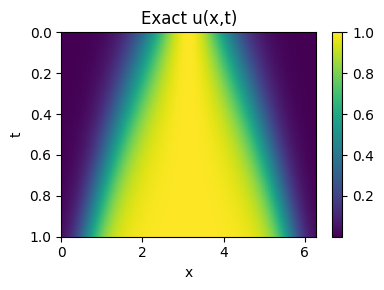

In [15]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

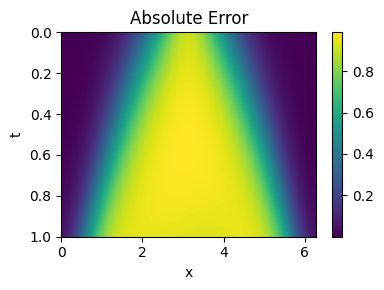

In [16]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()

In [17]:
# save model state dict
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'pinnsformer.pth')